In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import random
from numpy.linalg import inv
from sklearn.linear_model import LinearRegression
from statsmodels.tools.eval_measures import rmse
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from itertools import combinations


In [2]:
df_long = pd.read_excel("C:/Users\liuwe\Desktop\Daily\Research\ENEOS\Data_3/New_LSR/211213_根岸LSR平衡還流沸点データ.xlsx",
                     sheet_name='DataBase(432)', header=3, index_col=0, skiprows=range(4,5))
df_short= pd.read_excel("C:/Users\liuwe\Desktop\Daily\Research\ENEOS\Data_3/New_LSR/211213_根岸LSR平衡還流沸点データ.xlsx",
                     sheet_name='DataBase(122)', header=3, index_col=0, skiprows=range(4,5))

In [3]:
df_train, df_test = df_long.iloc[:315,:], df_short
y_train, date_train = df_train.pop('bp').values, df_train.pop('Date').values
y_test, date_test = df_test.pop('bp').values, df_test.pop('Date')

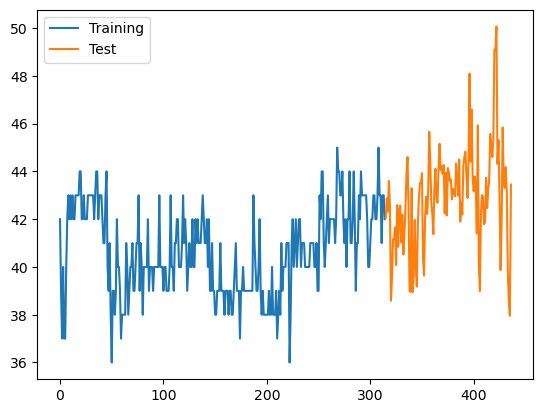

In [4]:
# plt.style.use('seaborn')
# plt.plot(date_train, y_train,label='Training')
# plt.plot(date_test, y_test,label='Test')
plt.plot(np.arange(y_train.shape[0]), y_train,label='Training')
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), y_test,label='Test')
plt.legend()

In [4]:
def mae(y,yh):
    return np.mean(np.abs(y-yh))

In [5]:
num = 45
X_train, X_test = df_train.iloc[:,:num], df_test.iloc[:,:num]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [87]:
decision_tree_reg = DecisionTreeRegressor(max_depth=5)
decision_tree_reg.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=5)

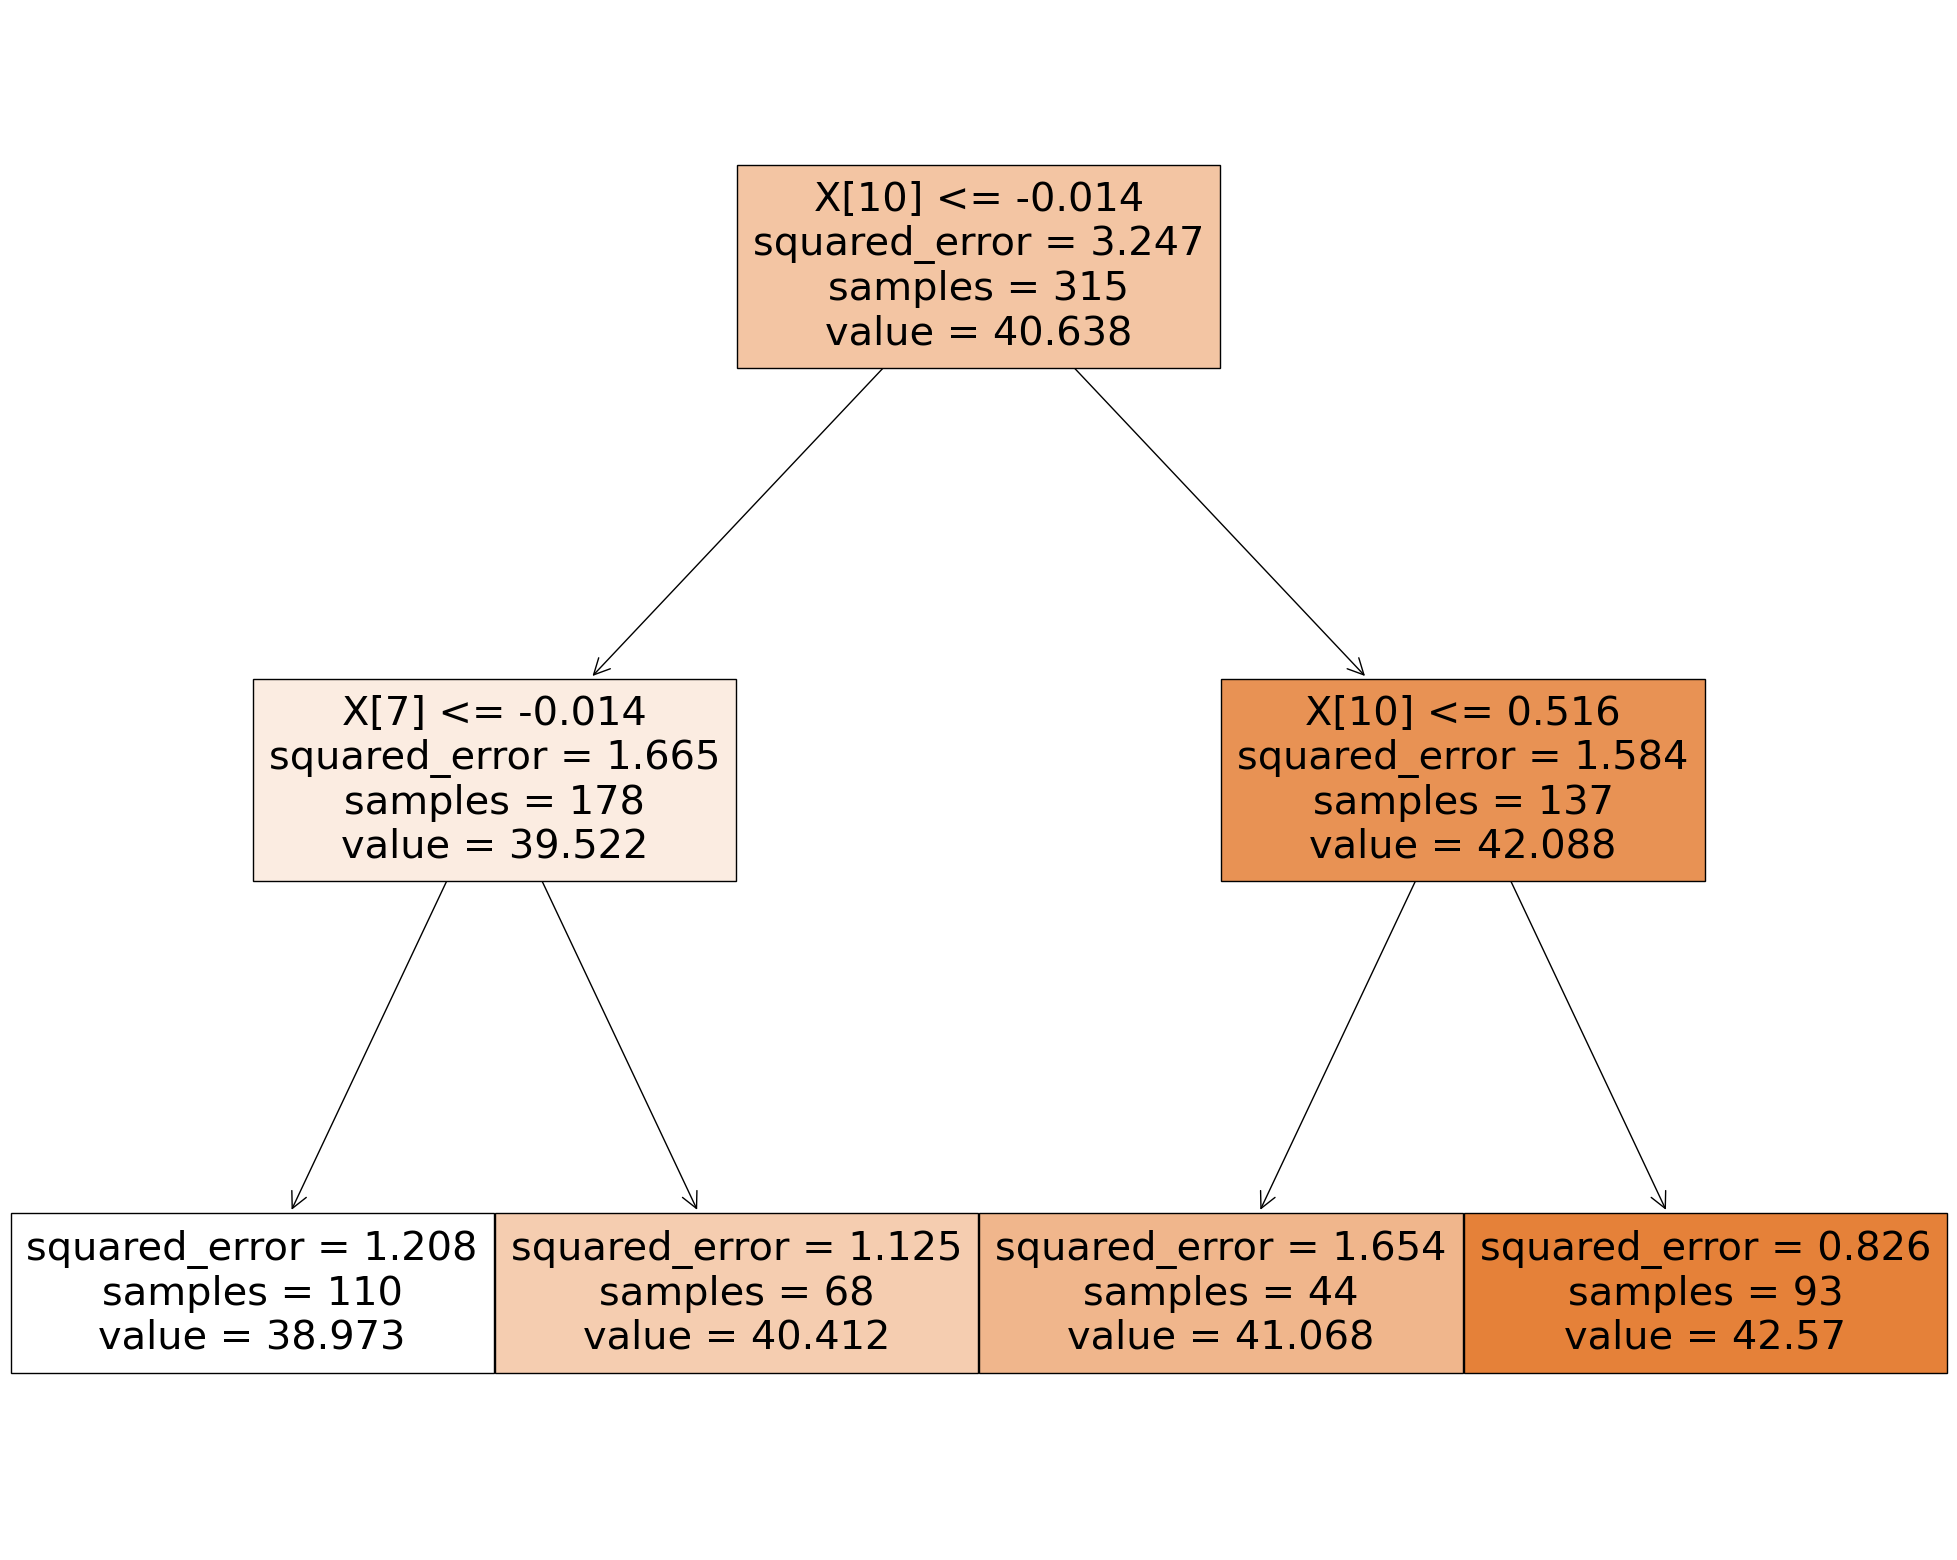

In [47]:
# tree_representation = tree.export_text(decision_tree_reg)
# print(tree_representation)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_tree_reg, filled=True)
fig.savefig('decision tree.png')

In [65]:
# Currently the best of OLS
f_s = np.array([10,13,14,17])
reg = LinearRegression().fit(X_train[:,f_s], y_train)
ytrhat = reg.predict(X_train[:,f_s])
ytehat = reg.predict(X_test[:,f_s])
print('Train RMSE: %.4f\nTrain MAE:  %.4f' % (rmse(ytrhat, y_train),mae(ytrhat, y_train)))
print('Test  RMSE: %.4f\nTest  MAE:  %.4f' % (rmse(ytehat, y_test),mae(ytehat, y_test)))

Train RMSE: 0.9400
Train MAE:  0.7320
Test  RMSE: 1.3774
Test  MAE:  1.0078


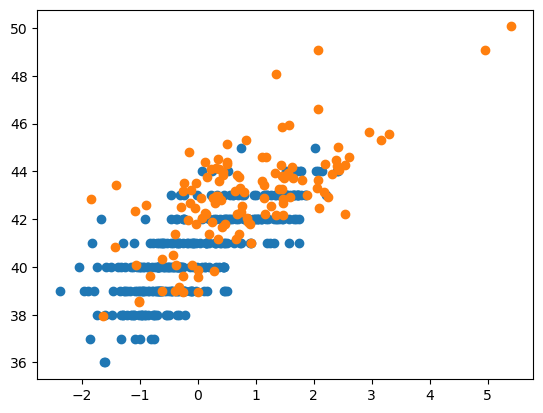

In [67]:

plt.scatter(X_train[:,10], y_train, label='Train')
plt.scatter(X_test[:,10], y_test, label='Test')

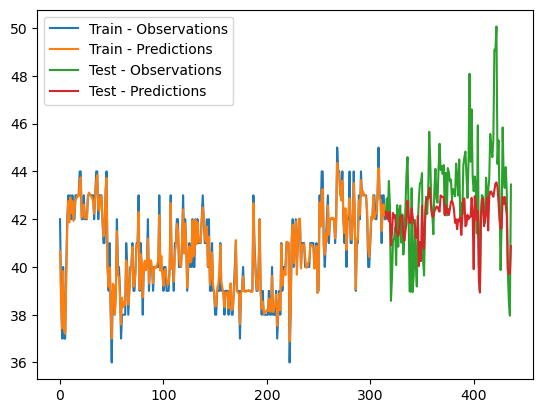

In [91]:
plt.plot(np.arange(len(y_train)), y_train, label='Train - Observations')
plt.plot(ytrhat, label='Train - Predictions')
plt.plot(np.arange(len(y_train), len(y_train)+len(y_test)), y_test, label='Test - Observations')
plt.plot(np.arange(len(y_train), len(y_train)+len(y_test)),ytehat, label='Test - Predictions')
plt.legend()

In [21]:
def MyKF(X_train, y_train, sigma_1, sigma_2):
    
    X_train = sm.add_constant(X_train)

    # Matrix dimension
    k_states = X_train.shape[1]
    nobs = X_train.shape[0] 

    # Allocate memory for all kinds of process variables
    filtered_state = np.zeros((k_states, nobs))
    filtered_state_cov = np.zeros((k_states, k_states, nobs))
    predicted_state = np.zeros((k_states, nobs+1))
    predicted_state_cov = np.zeros((k_states, k_states, nobs+1))
    prediction = np.zeros((1, nobs))
    prediction_error_cov = np.zeros((1, 1, nobs))

    # Initial state and state_cov
    res = sm.OLS(y_train, X_train).fit()
    predicted_state[:,0] = res.params[:]
    predicted_state_cov[:,:,0] = np.diag([0.05]*k_states)


    for t in range(nobs):
        X = X_train[t,:].reshape((1,-1))
        # one step ahead prediction
        prediction[:,t] = X @ predicted_state[:,t]
        prediction_error_cov[:,:,t] = X @ predicted_state_cov[:,:,t] @ X.T + sigma_2

        # Adjust the prediction with the incoming observation to filter the state and state_cov
        KalmanGain = predicted_state_cov[:,:,t] @ X.T @ inv(prediction_error_cov[:,:,t])
        filtered_state[:,t] = predicted_state[:,t] + KalmanGain @ (y_train[t]-prediction[:,t])
        filtered_state_cov[:,:,t] = predicted_state_cov[:,:,t] - KalmanGain @ prediction_error_cov[:,:,t] @ KalmanGain.T

        # predict the state and state cov for the next step
        predicted_state[:,t+1] = filtered_state[:,t]
        predicted_state_cov[:,:,t+1] = filtered_state_cov[:,:,t] + sigma_1
    return prediction.ravel(), prediction_error_cov.ravel(), filtered_state, filtered_state_cov, predicted_state, predicted_state_cov

In [23]:
# off-line forecasting
def myKF_offlineForecast(X_test, sigma_1, sigma_2, pred_sta, pred_sta_cov):
    X_test = sm.add_constant(X_test)
    k_states = X_test.shape[1]
    nobs = X_test.shape[0]
    predicted_state_cov = np.zeros((k_states, k_states, nobs+1))
    prediction_cov = np.zeros((1, nobs))
    ytehat = X_test @ pred_sta[:,-1]
    predicted_state_cov[:,:,0] = pred_sta_cov[:,:,-1]
    for t in range(0, nobs):
        X_current = X_test[t, :].reshape((1,-1))
        prediction_cov[:,t] = X_current @ predicted_state_cov[:,:,t] @ X_current.T + sigma_2
        predicted_state_cov[:,:,t+1] = predicted_state_cov[:,:,t] + sigma_1
    return ytehat.ravel(), prediction_cov.ravel()

In [ ]:
splits = 5
tscv = TimeSeriesSplit(n_splits=splits)
# Random row selection
train_error = test_error = 0
sampled_order = random.sample(range(0, len(feature_set_pool)), 1000)
for train_index, test_index in tscv.split(X_train):
    # random column selection
    for col in sampled_order:
        X, y = X_train[np.ix_(train_index,feature_set_pool[col])], y_train[train_index]
        # System noise and measurement noise
        sigma_1 = np.diag([0.0001]*(len(feature_set_pool[col])+1)) # state_cov
        sigma_2 = 0.25 # res.scale # obs_cov
        result = MyKF(X, y, sigma_1, sigma_2)
        ytrhat = result[0]
        ytehat = sm.add_constant(X_test[:,feature_set_pool[col]]) @ result[4][:,-1]
        train_error += rmse(ytrhat, y)
        test_error  += rmse(ytehat, y_test)

# model_num = splits * len(list(combinations(list_f,num_f)))
model_num = splits * len(sampled_order)
train_error /= model_num
test_error /= model_num

print('Train error: %.4f\nTest error: %.4f' %(train_error, test_error))

In [59]:
feature_set_pool = []
for i in range(5,7):
    feature_set_pool += list(combinations(np.arange(45),i))
print(len(feature_set_pool))

9366819


In [63]:
# Model combinations for OLS
splits = 5
tscv = TimeSeriesSplit(n_splits=splits)
# Random row selection
train_error = test_error = 0
sampled_order = random.sample(range(0, len(feature_set_pool)), 500)
for train_index, test_index in tscv.split(X_train):
    # random column selection
    for col in sampled_order:
        X, y = X_train[np.ix_(train_index,feature_set_pool[col])], y_train[train_index]
        reg = LinearRegression().fit(X, y)
        ytrhat = reg.predict(X)
        ytehat = reg.predict(X_test[:,feature_set_pool[col]])
        train_error += rmse(ytrhat, y)
        test_error  += rmse(ytehat, y_test)

# model_num = splits * len(list(combinations(list_f,num_f)))
model_num = splits * len(sampled_order)
train_error /= model_num
test_error /= model_num

print('Train RMSE: %.4f\nTest RMSE: %.4f' %(train_error, test_error))

Train RMSE: 1.0069
Test RMSE: 2.7004


In [38]:
class KalmanFilter(sm.tsa.statespace.MLEModel):
    def __init__(self, y_t, exog):
        exog = sm.add_constant(exog)

        super(KalmanFilter, self).__init__(
            endog=y_t, exog=exog, k_states=exog.shape[1]
        )
        # initialization="diffuse" -> When assume no prior knowledge of the state and state_cov

        self.ssm["design"] = exog.T[np.newaxis, :, :]  # shaped 1 x k_states x nobs
        self.ssm["selection"] = np.eye(self.k_states)
        self.ssm["transition"] = np.eye(self.k_states)
        self.k_exog = self.k_states 
        
        # Initialize using known distribution
        # When use the state_cov by OLS (res.normalized_cov_params), the variances are very small,
        # leading the model to rely on this initial estimate too much, thus causes overfitting.
        # As a work around, use the initial state estimate, but increase its covariance matrix by value.
        res = sm.OLS(self.endog, self.exog).fit()
        self.initialize_known(initial_state=res.params[:], initial_state_cov=np.diag([5]*self.k_states))

        # Which parameters need to be positive?
        # Positive constraint setting is very important.
        # MAKE SURE the LENGTH is CORRECT.
        self.positive_parameters = slice(0, self.k_states+2)

    @property
    def param_names(self):
        return ["epsilon"] + ['var.p' + str(i) for i in range(self.k_states)]

    @property
    def start_params(self):
        """
        Defines the starting values for the parameters
        The linear regression gives us reasonable starting values for the constant
        d and the variance of the epsilon error
        """
        # exog = sm.add_constant(self.exog)
        exog = self.exog
        res = sm.OLS(self.endog, exog).fit()
        params = np.r_[res.scale, [0.01]*(self.k_exog)]
        return params

    def transform_params(self, unconstrained):
        """
        We constraint the variances to be positive
        """
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = (
            constrained[self.positive_parameters] ** 2
        )
        return constrained

    def untransform_params(self, constrained):
        """
        Need to unstransform all the parameters you transformed
        in the `transform_params` function
        """
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = (
            unconstrained[self.positive_parameters] ** 0.5
        )
        return unconstrained

    def update(self, params, **kwargs):
        params = super(KalmanFilter, self).update(params, **kwargs)

        
        self["obs_cov", 0, 0] = params[0]
        self["state_cov"] = np.diag(params[1:(self.k_exog+2)])
        
    def clone(self, endog, exog=None, **kwargs):
        return self._clone_from_init_kwds(endog, exog=exog, **kwargs)

In [42]:

splits = 5
tscv = TimeSeriesSplit(n_splits=splits)
# Random row selection
train_error = test_error = 0
sampled_order = random.sample(range(0, len(feature_set_pool)), 1000)
for train_index, test_index in tscv.split(X_train):
    # random column selection
    for col in sampled_order:
        X, y = X_train[np.ix_(train_index,feature_set_pool[col])], y_train[train_index]
        result = KalmanFilter(y, X).fit()
        ytrhat = result.get_prediction().predicted_mean
        ytehat = result.get_forecast(X_test.shape[0], exog=sm.add_constant(X_test[:,feature_set_pool[col]])).predicted_mean
        train_error += rmse(ytrhat, y)
        test_error  += rmse(ytehat, y_test)

# model_num = splits * len(list(combinations(list_f,num_f)))
model_num = splits * len(sampled_order)
train_error /= model_num
test_error /= model_num

print('Train error: %.4f\nTest error: %.4f' %(train_error, test_error))

c:\Users\liuwe\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\liuwe\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\liuwe\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\liuwe\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Train error: 1.2238
Test error: 3.1620
